# Crevasse model with a single parameter set
This note book looks in detail at individual solutions.  Another notebook looks at ensembles of solutions over different parts of the parameter space.

In [1]:
# The following few lines of code are unethical and shouldn't be used every again. But they work.
import os
os.environ['PATH'] = "/home/bradlipovsky/anaconda3/envs/fenicsproject/bin:" + os.environ['PATH']
print(os.environ['PATH'])

/home/bradlipovsky/anaconda3/envs/fenicsproject/bin:/usr/local/sbin:/usr/local/bin:/usr/sbin:/usr/bin


In [2]:
from dolfin import *
from mshr import *
import matplotlib.pyplot as plt
%matplotlib notebook
from time import perf_counter
import numpy as np
import pickle
from os import path

import crevasse as c # main module for this project
from importlib import reload
reload(c)

<module 'crevasse' from '/home/bradlipovsky/notebooks/Near-Front-Crevasses/crevasse.py'>

## Define baseline parameters

In [3]:
# Geometry: domain width, domain height,  crevasse location, crevasse width, crevasse height
geom = {'W':60000,'H':300,'Lc':15, 'Wc':1, 'Hc': 5}

# Materials: Youngs modulus, poisson ratio, ice density, water density, gravity
mats = {'E':1e10, 'nu':0.3, 'rho':910, 'rhow':1024, 'g':9.81}

## Define the FEM solution

In [4]:
geom['H'] = 200
mats['E'] = 1e9
geom['fl']=10
U,mesh = c.elasticity_solutions(geometry=geom, materials=mats, refinement=1,verbose=True)

# For higher levels of refinement, use run_single_model.py.  
# Here, we just load the output:
# mesh = Mesh("example_mesh.xml")
# V = VectorFunctionSpace(mesh, 'CG', 2)
# U = Function(V)
# fFile = HDF5File(MPI.comm_world,"example_output.h5","r")
# fFile.read(U,"/f")

Running full-minus-prestress model:
     Generating Mesh
     Creating forms
     Applying swell boundary condition on the ice front
     Applying swell boundary condition on the ice bottom
     SOLVING
Results:
     Vertical deflection:
         Numerical:  0.299715
x0=10.000000
     Horizontal deflection:
         Numerical:  5.393612
 


## Plot the mesh

<IPython.core.display.Javascript object>


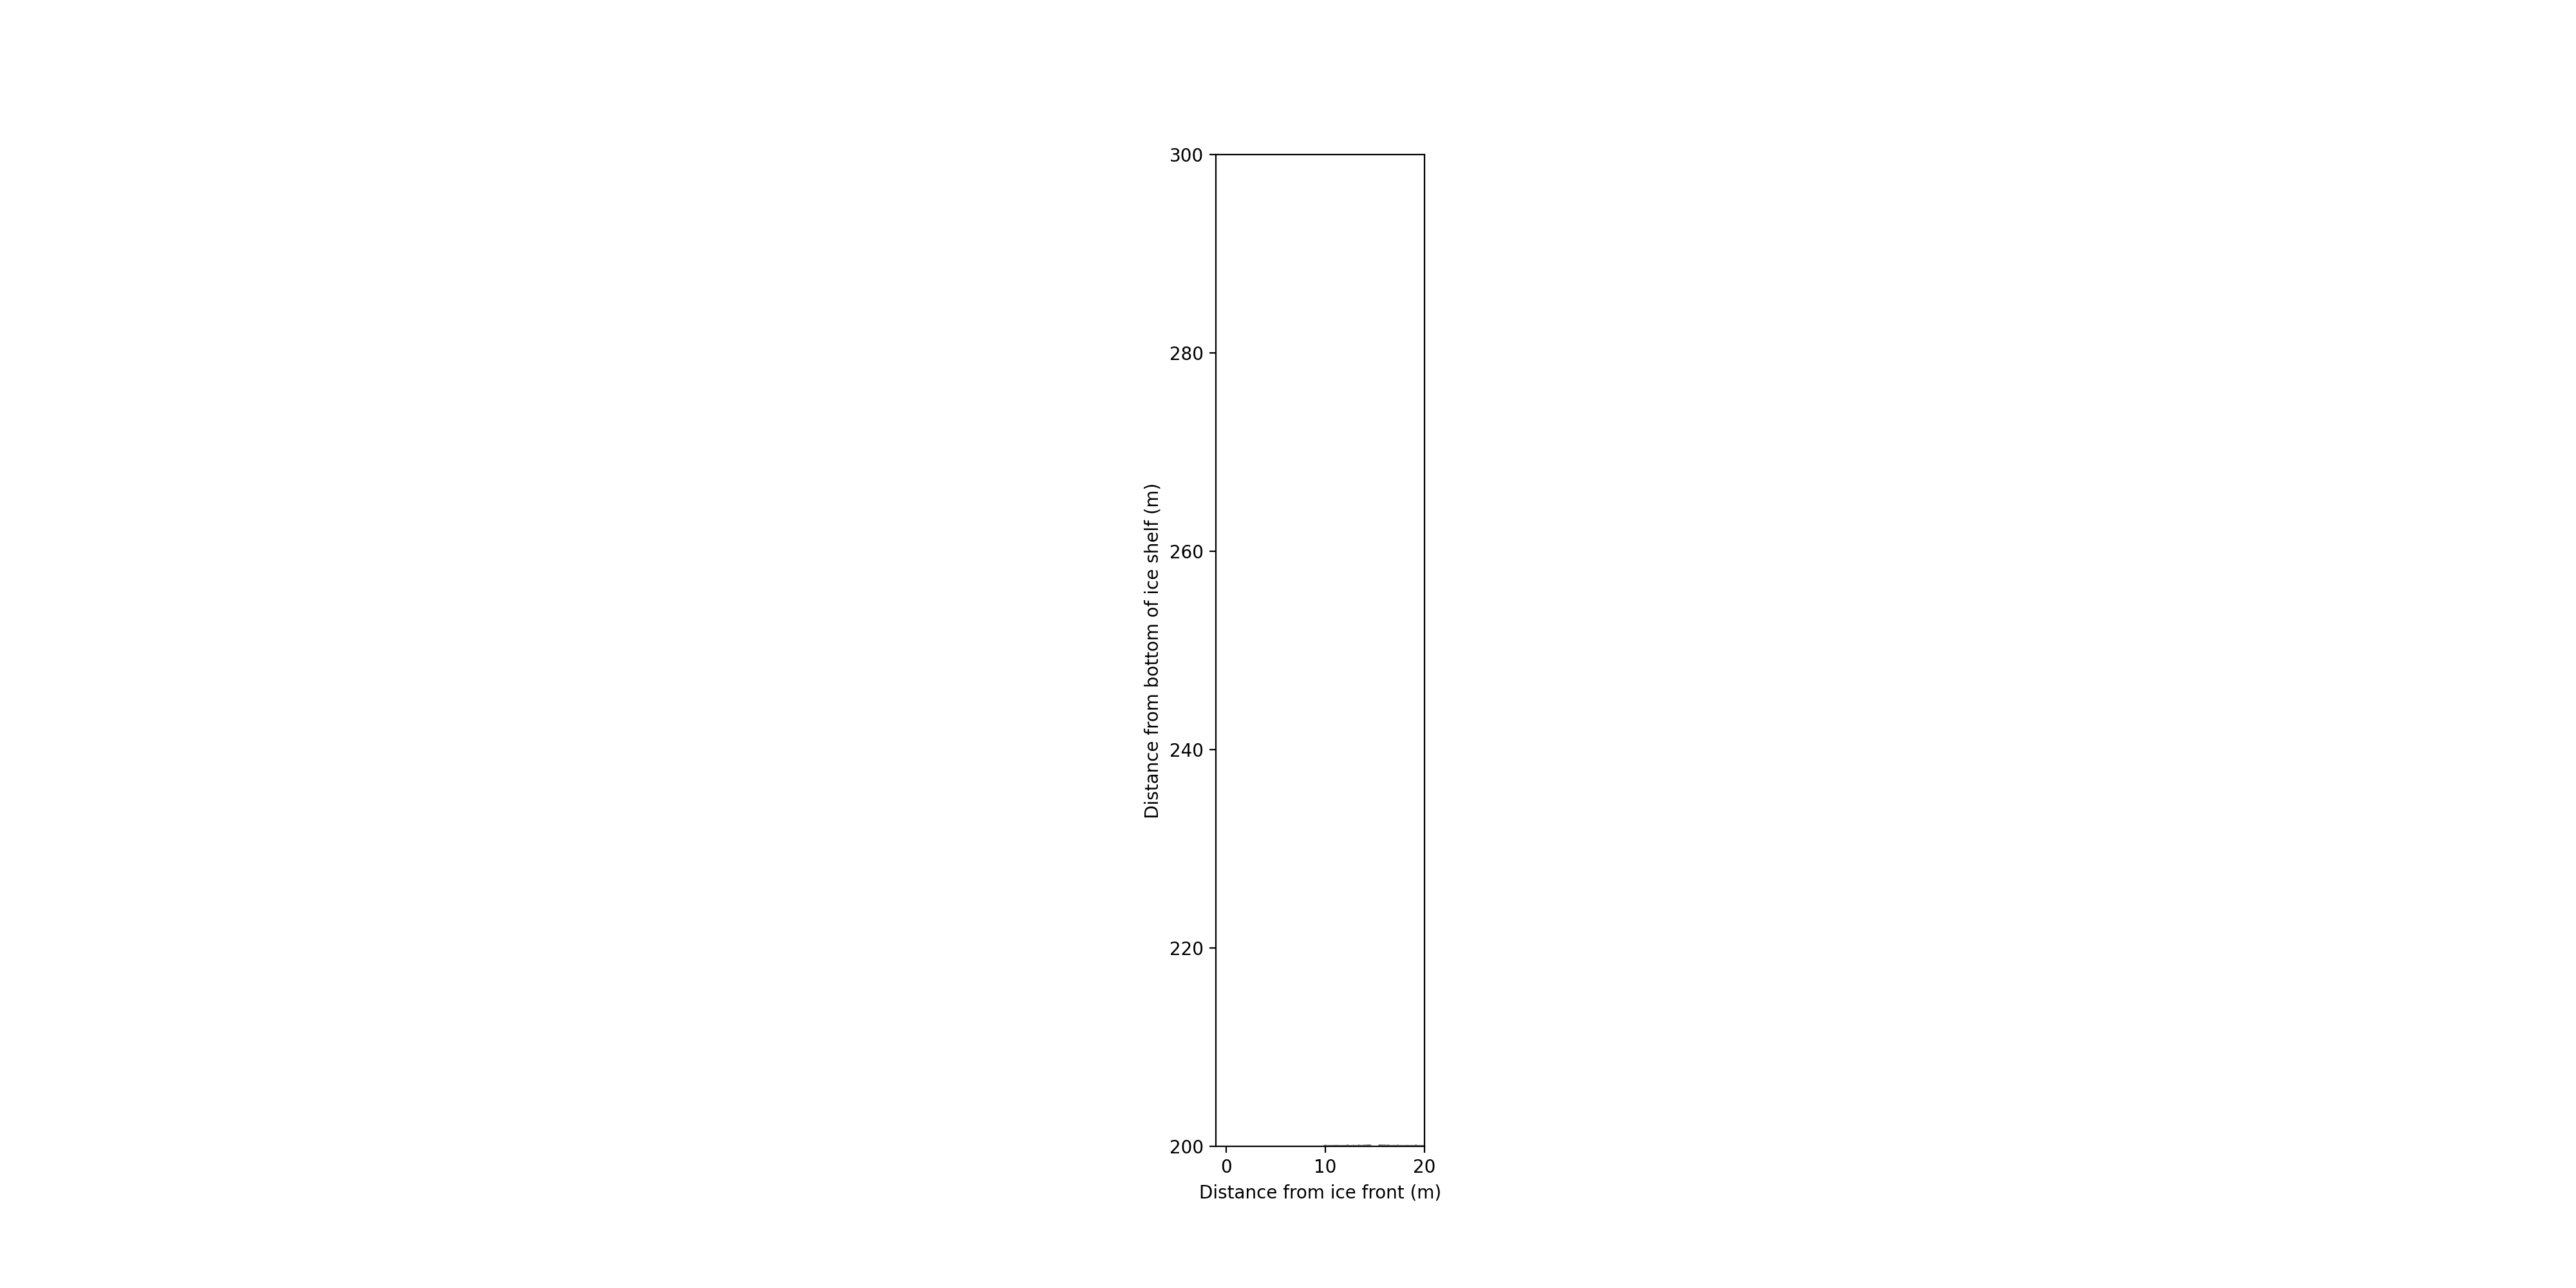

In [5]:
Hw = mats['rho']/mats['rhow']*geom['H']
fig,ax=plt.subplots(figsize=(10,5))
plot(mesh)
ax.set_xlim([-1,20])
ax.set_ylim([200,300])
# plt.plot(0,Hw,'or')
plt.xlabel('Distance from ice front (m)')
plt.ylabel('Distance from bottom of ice shelf (m)')
# plt.savefig('figures/example_mesh.eps', format='eps')
plt.show()

<IPython.core.display.Javascript object>


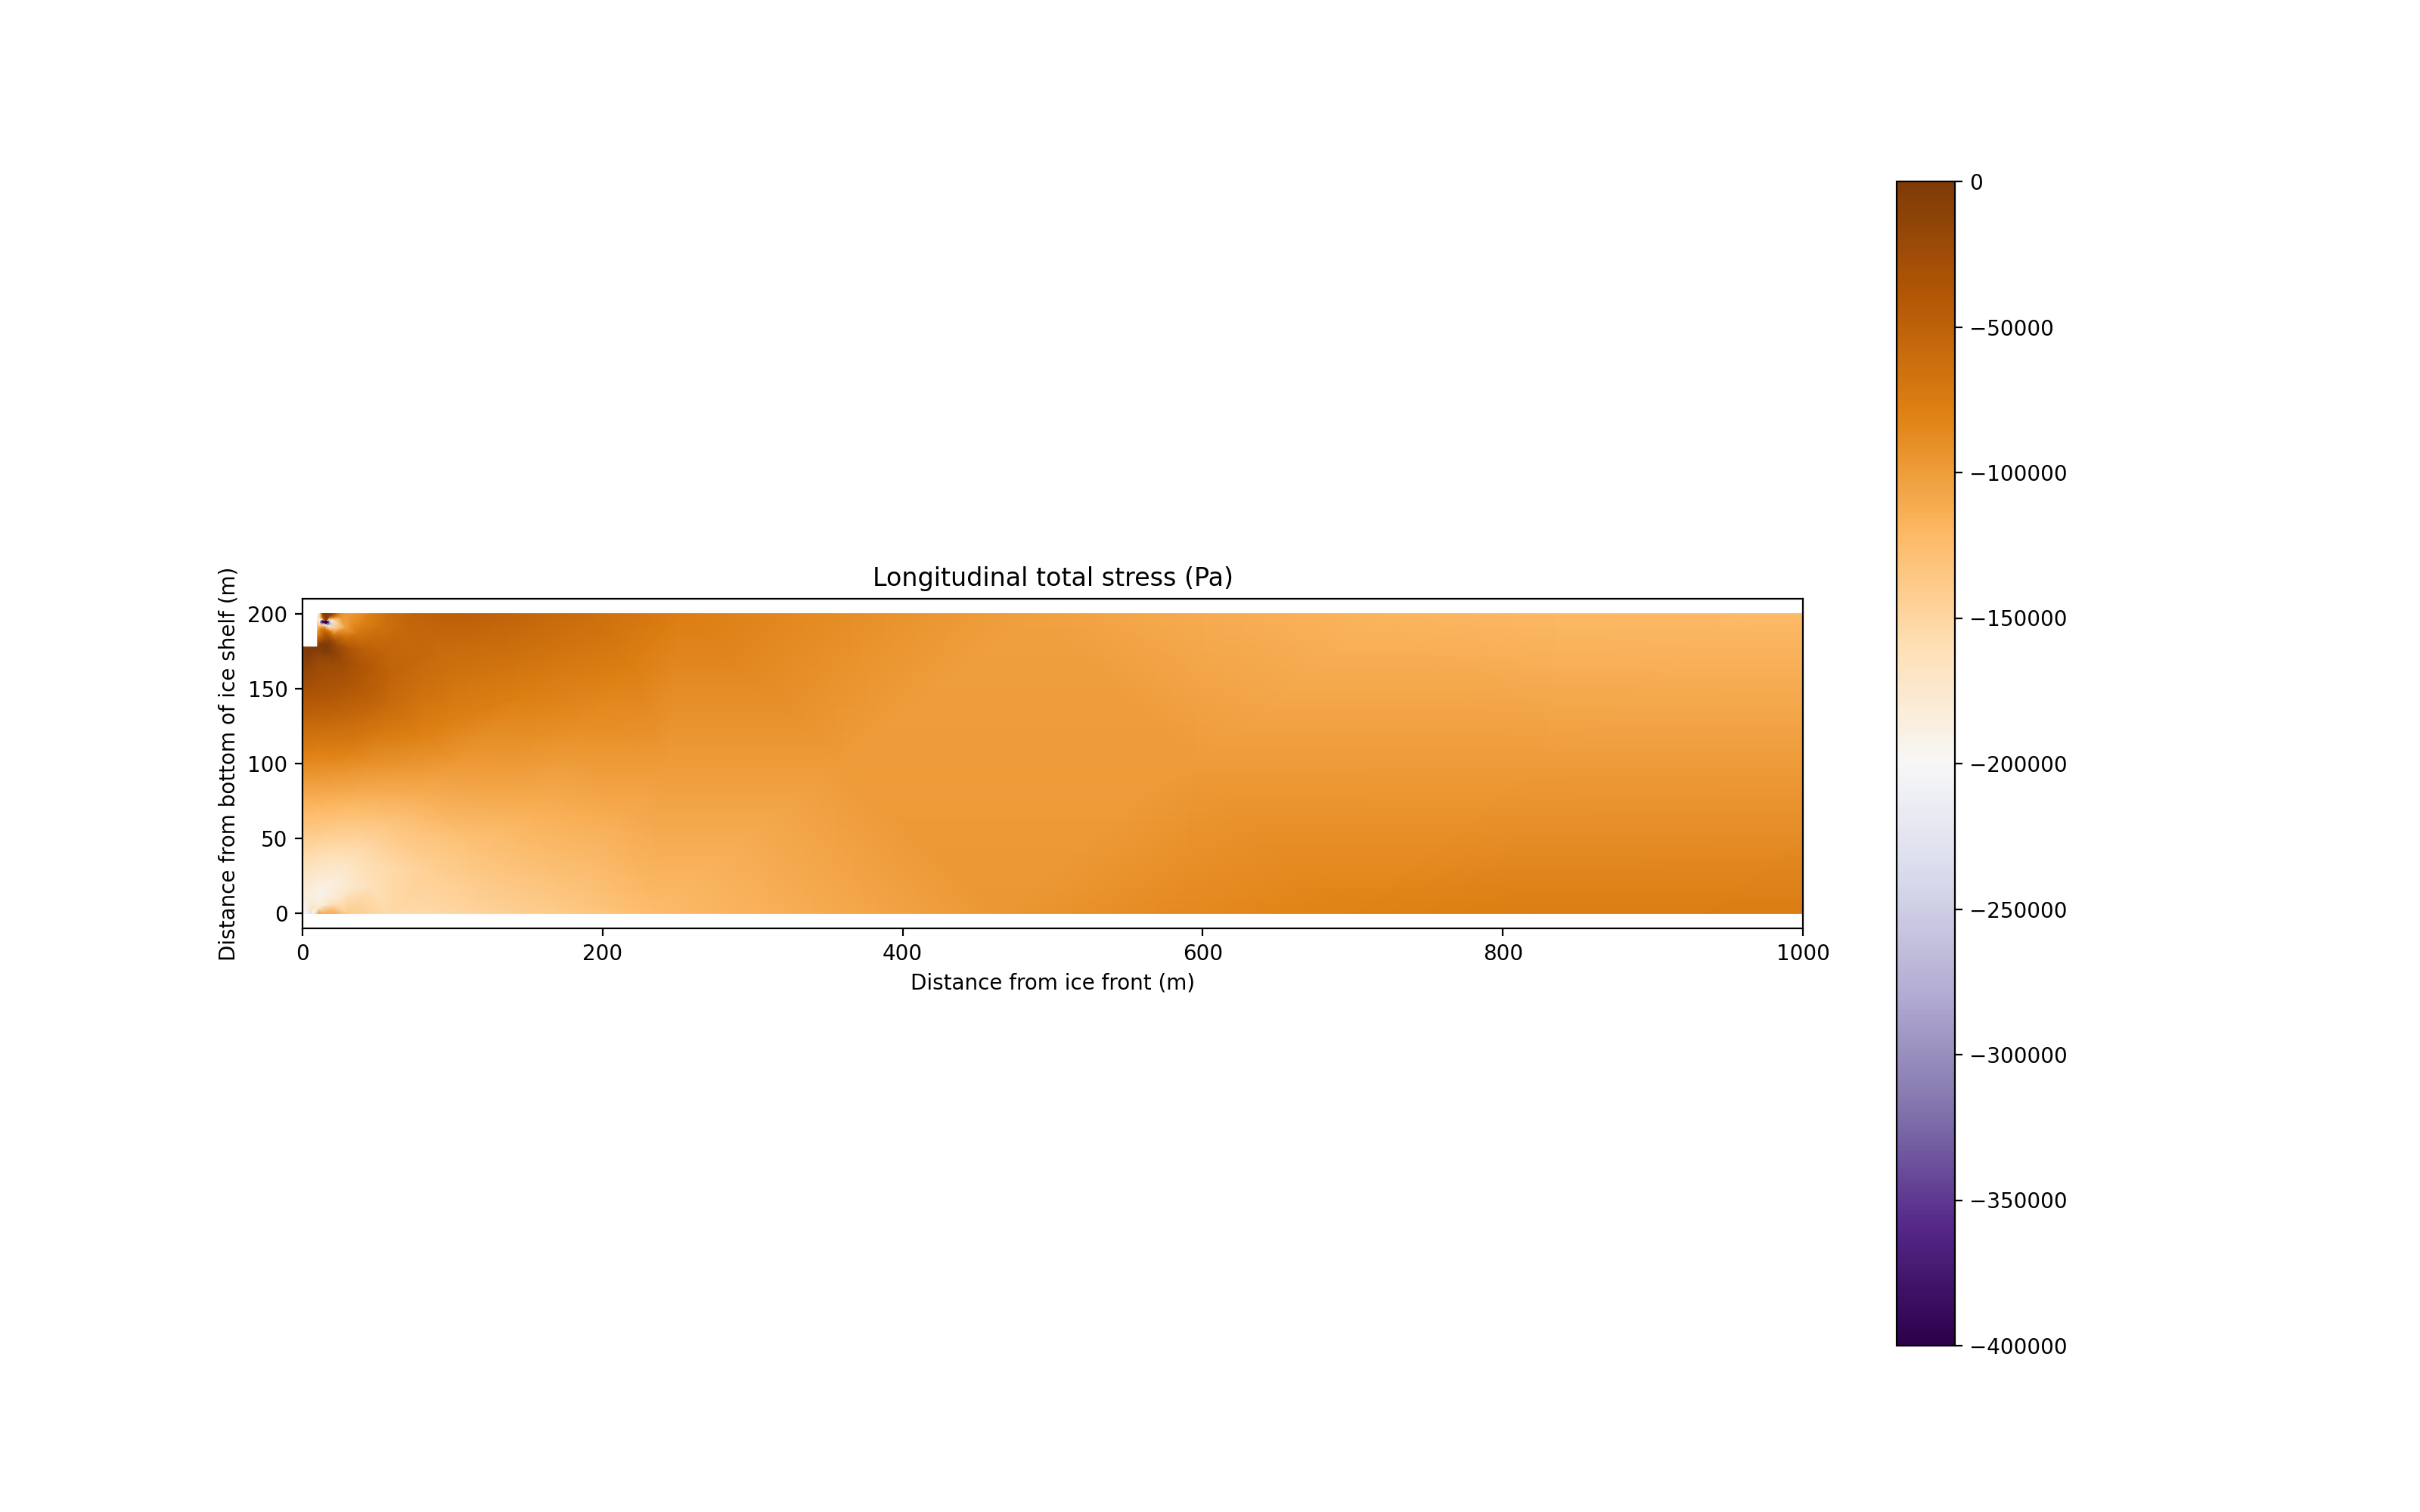

In [6]:
mats['mu'] = mats['E']/2./(1+mats['nu'])
mats['lmbda'] = mats['E']*mats['nu']/(1+mats['nu'])/(1-2*mats['nu'])

fig,ax=plt.subplots(figsize=(8,5))

this_plot=plot(c.sigma(U,mats['lmbda'],mats['mu'])[0,0],
               mode='color',cmap='PuOr_r',
               vmin=-4e5,vmax=0e5)

ax.set_xlim([0,1000])
plt.show()

plt.xlabel('Distance from ice front (m)')
plt.ylabel('Distance from bottom of ice shelf (m)')
plt.title('Longitudinal total stress (Pa)')
plt.colorbar(this_plot)

# plt.savefig('figures/example_simulation.eps', format='eps')

# fig,ax=plt.subplots()
# plot(mesh)
# ax.set_xlim((0,1000))
# plt.show()

<IPython.core.display.Javascript object>


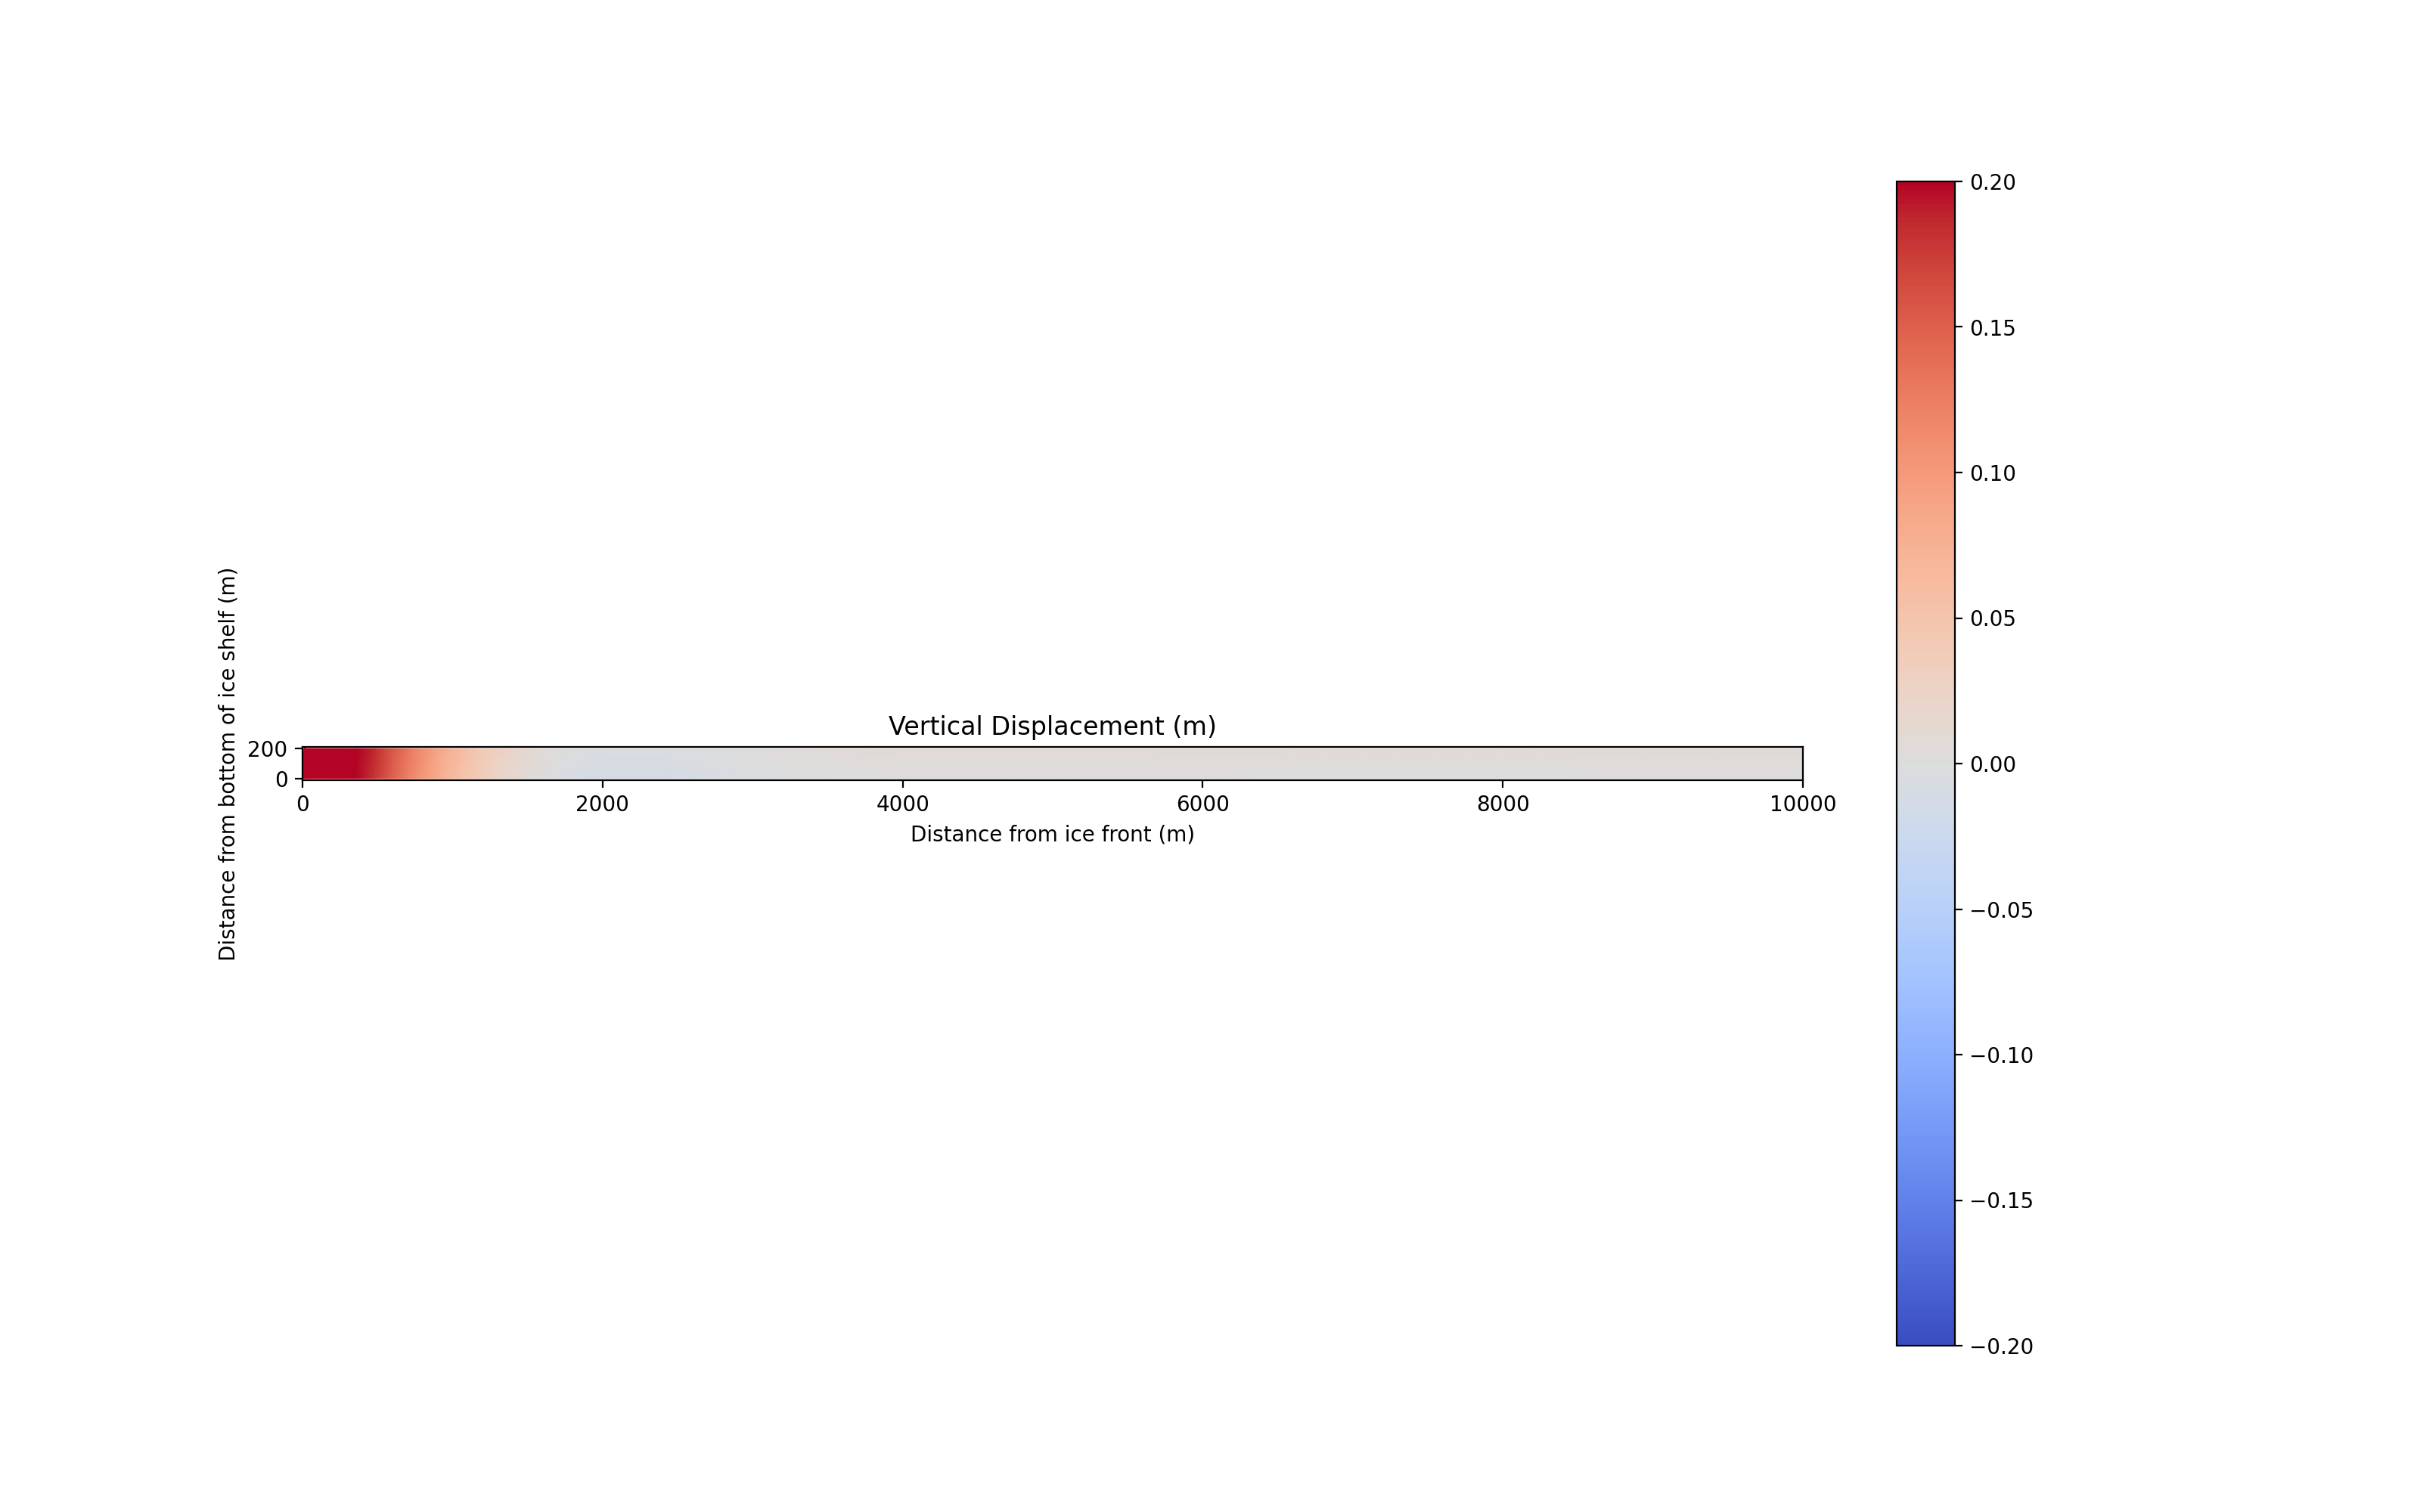

In [7]:
fig,ax=plt.subplots(figsize=(8,5))
this_plot=plot(U[1],mode='color',vmin=-0.2,vmax=0.2,cmap='coolwarm')

ax.set_xlim([0,10000])
plt.show()


plt.xlabel('Distance from ice front (m)')
plt.ylabel('Distance from bottom of ice shelf (m)')
plt.title('Vertical Displacement (m)')
plt.colorbar(this_plot)

# plt.savefig('figures/example_simulation.eps', format='eps')

# fig,ax=plt.subplots()
# plot(mesh)
# ax.set_xlim((0,1000))
# plt.show()

In [8]:
# slic = []
# Nx = 100
# xr = np.linspace(0,geom['W'],Nx)


# fig=plt.subplots()

# for x in xr:
#     slic.append( U( x, geom['H'])[1] )

# ax = plt.subplot(2,1,1)     
# # ax.patch.set_facecolor('xkcd:mint green')
# ax.plot(xr,slic)
# ax.set_ylabel('Vertical displacement')
# # plt.ylim((-0.8,0.2))

# slic = []
# for x in xr:
#     slic.append( U( x, geom['H'])[0] )
# ax = plt.subplot(2,1,2)      
# ax.plot(xr,slic)
# ax.set_ylabel('Horizontal displacement')
# #     c=plot(u[0],mode='color',vmin=0)
# #     plt.colorbar(c)
# plt.grid()
# #     plt.legend()
# plt.show()

# Test the beam solution

<IPython.core.display.Javascript object>


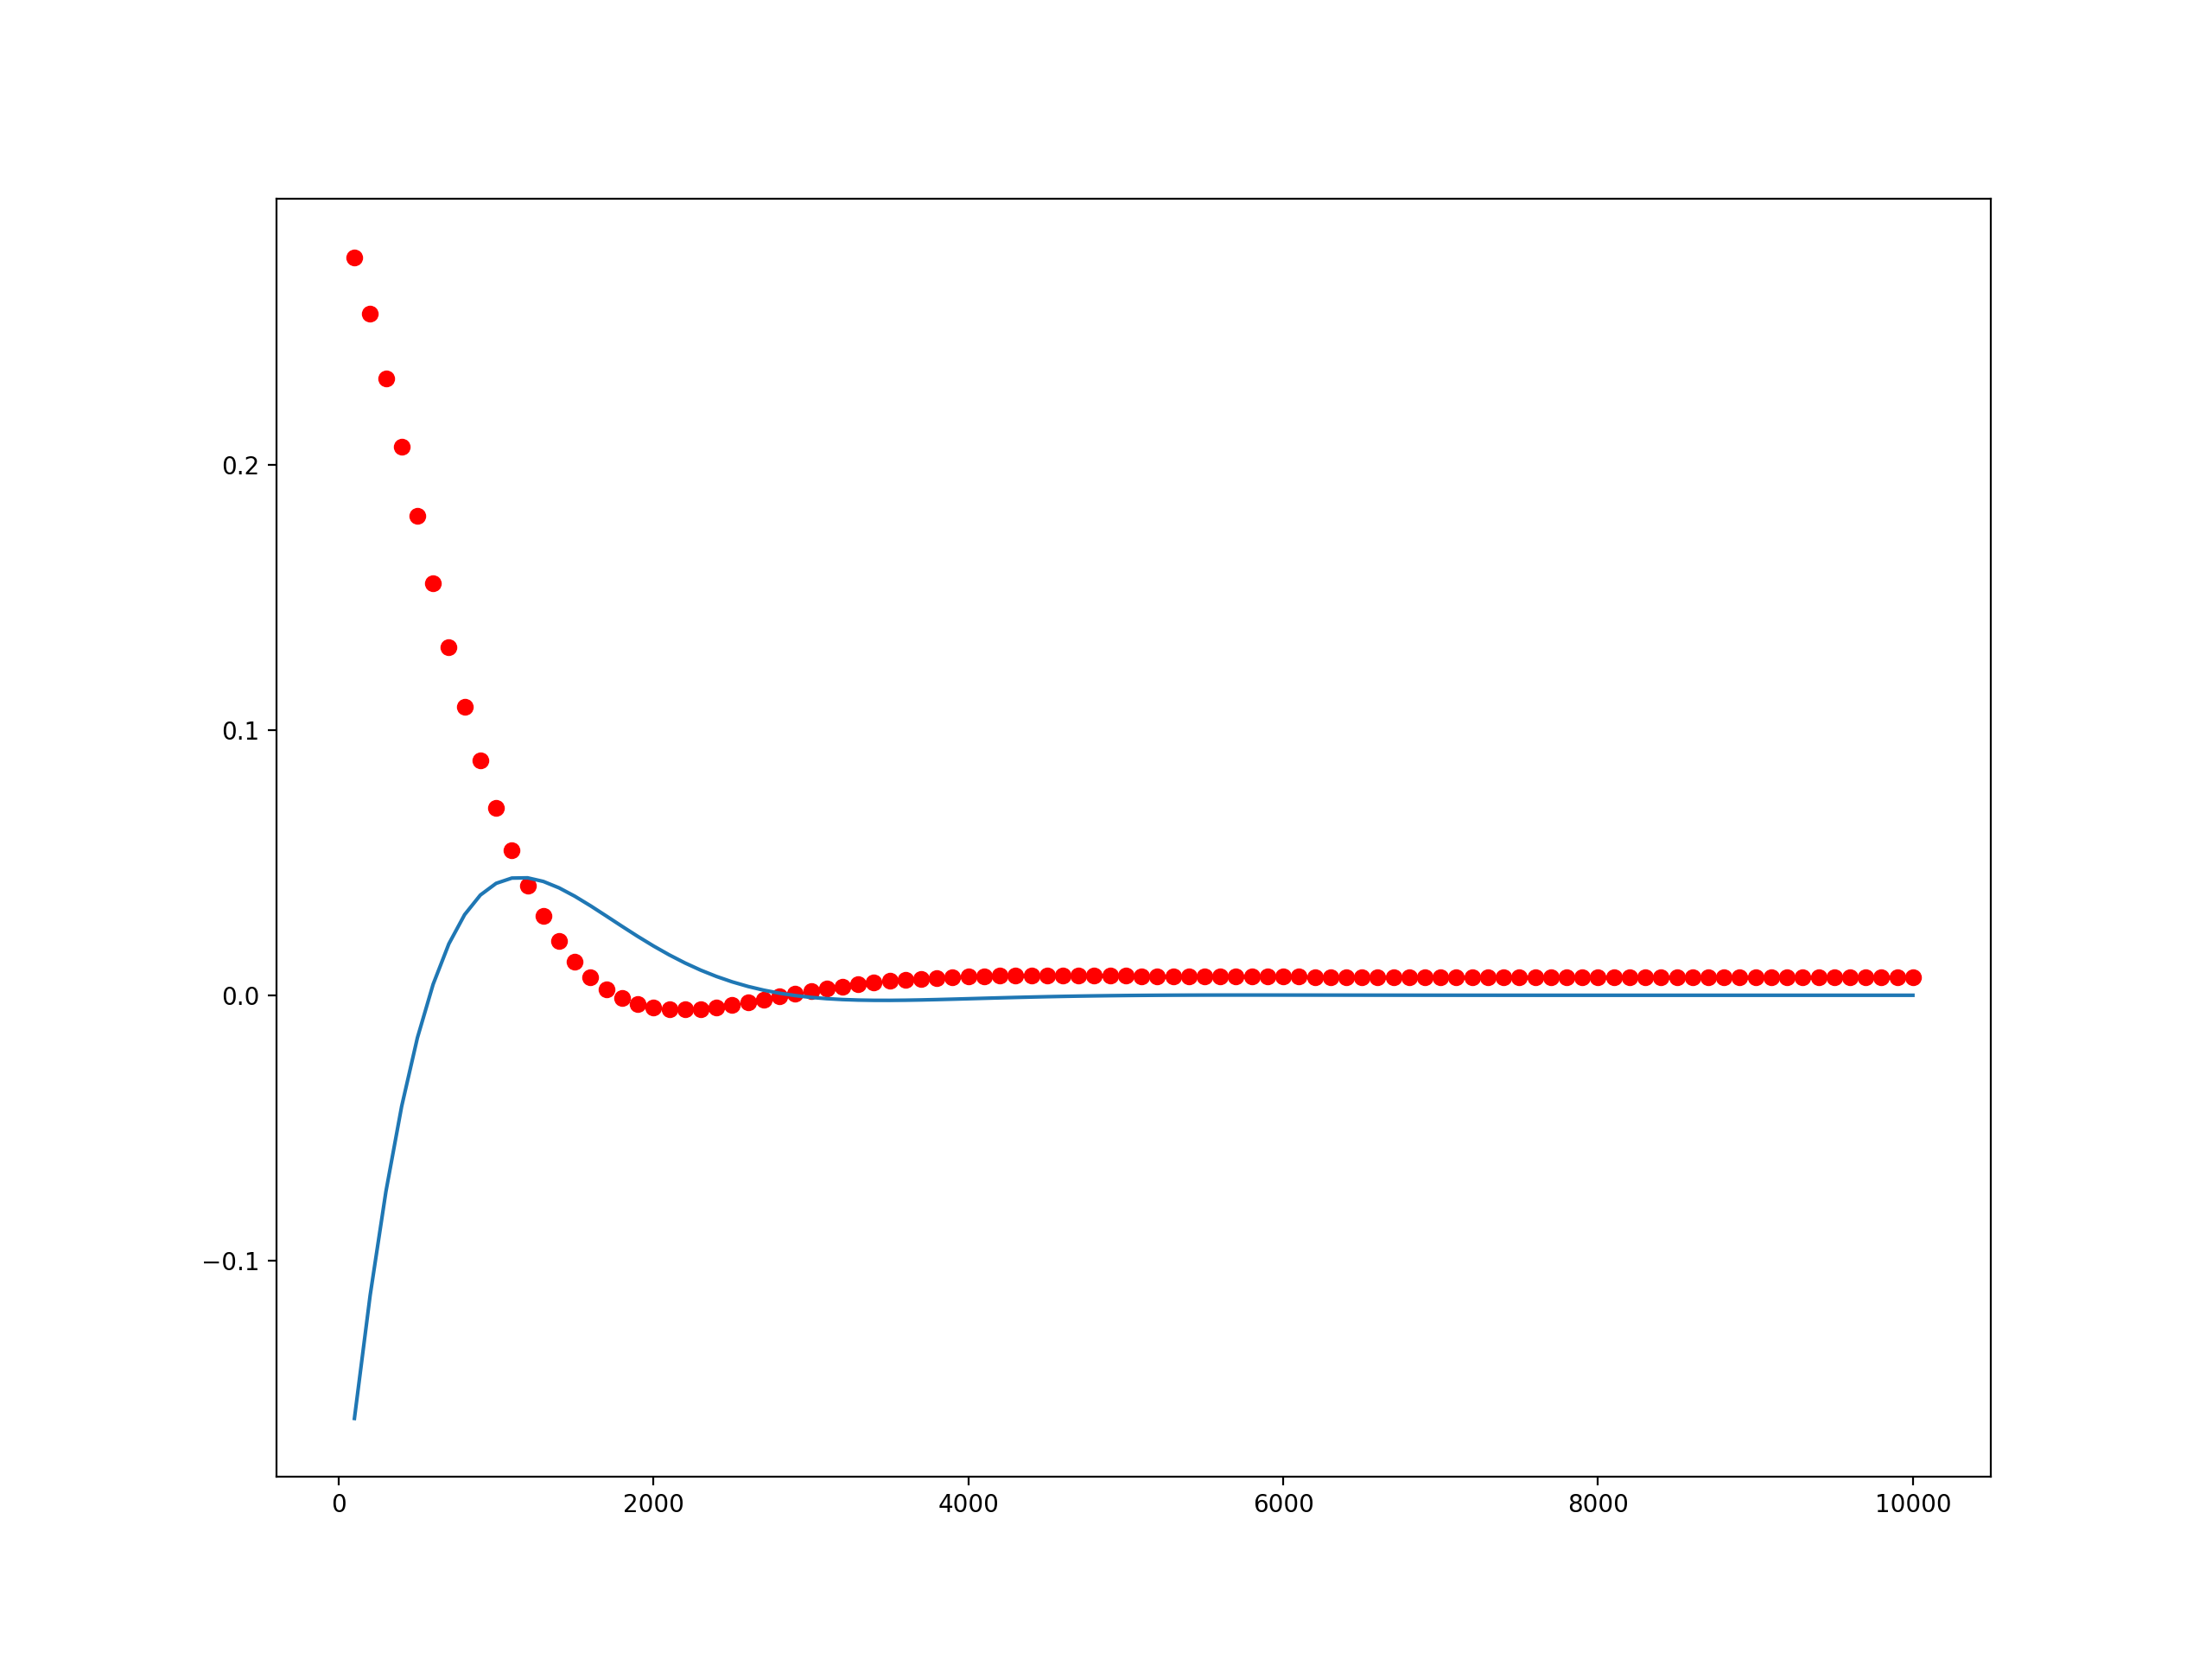

In [9]:
Lcs = np.linspace(100,10000,100)

D, flexural_gravity_wavelength, lam = c.fgl(mats,geom)

r = mats['rho']/mats['rhow']
m0 = mats['rho']*mats['g']*geom['H']**3 / 12 * (3*r - 2*r**2 - 1)

w_flex =  -  2 * m0 / lam**2 / mats['rho'] / mats['g'] \
            * np.exp(-Lcs/lam)*(np.cos(Lcs/lam) - np.sin(Lcs/lam))

w_flex = w_flex 

w_fem = []
for x in Lcs:
    w_fem.append(U((x,geom['H']*.9))[1])

fig=plt.subplots()
plt.plot(Lcs,w_fem,'or')
plt.plot(Lcs,w_flex)